# Notebook 2.6.1: Epidemiology (The SIR Model)

---

<br>

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

<br>

---

In [2]:
#@title
#@ Import necessary libraries
from os.path import basename, exists
from os import mkdir

def download(url,folder):
    filename = folder + basename(url)
    if not exists(folder):
        mkdir(folder)
    # fetches the file at the given url if it is not already present
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/modsim.py', 'ModSimPy_Functions/')

from ModSimPy_Functions.modsim import *
import pandas as pd
import numpy as np

Downloaded ModSimPy_Functions/modsim.py


We solved our coffee cooling problem using Newton's Law of Cooling, which we implemented both analytically (as a continous function) and computationally (using discrete time steps).  But as systems get more complicated, analytical solutions become rarer.   

<br>

In this notebook, we'll develop a model of an epidemic as it spreads in a
susceptible population, and use it to evaluate the effectiveness of
possible interventions.  The spread of disease depends on multiple variables: how many people are infected? how many are recovered? how many have not been infected at all?  Such a system can be modeled as a *system of differential equations*: multiple DEQs that are interdependent.  We'll need to depend on computational methods to understand the behavior of this system.

<br>

Once we've built our model, we'll use it to explain the progression of
the disease over the course of the semester, predict the effect of
possible interventions (like immunization) and design the most effective intervention campaign

---

## The Kermack-McKendrick Model

Every year at Augustana, a crowd of new students come to campus from
around the country and the world. Most of them arrive healthy and happy, but usually at least one brings with them some kind of infectious disease. A few weeks later, predictably, some fraction of the incoming class comes down with what we call the "Freshman Plague".


<br>

We want to model this system, but it is quite complicated.  We'd need to know a fair bit about infectious diseases just to get started.  Rather than starting from scratch, we are going to borrow an existing model, called the Kermack-McKendrick (KM) model and implement it. Along the way, we will consider the way it abstracts the system, and identify the capabilities and
limitations that result from these abstraction decisions.


### Representing the state of the system in the KM model

One of the beautiful things about the KM model is that it is built from the ground up by making some basic assumptions about how disease behaves in a human population.

<br>

The first of these assumptions concerns how we can describe the *state* of the system.  KM is an example of an *SIR model*,
so-named because it divides a system (i.e. a group of people) into three categories:

-   *S*: "Susceptible" people are people who are capable of contracting the disease if they come into contact with someone who is infected.  So a "susceptible" person is not sick, and has no immunity to the infection.

-   *I*: "Infectious" people are currently sick, and so capable of passing along the disease if they come into contact with a "susceptible" person.

-   *R*: "Recovered" people have been infected but recovered. In the basic version of the model, people who have recovered are considered to be immune to
reinfection and are not capable of infecting others. 

It's important to note that this is a fairly intuitive way to describe the system: people are either not sick, sick, or recovered.  But recognize, too, that it is not without flaws: recovery equates to immunity for some diseases but not for others, for instance, so it should be on our mental list of simplifying abstractions.

<br>

The KM model also assumes that the population is closed; that is, no one
arrives or departs, so the size of the population is constant.

<br>

✅ Active Reading: Consider your experience with Covid over the last several years.  How might the category "susceptible" perhaps too simple?  In what ways are some uninfected people more or less susceptible than others?  Answer in a text cell here.

### Representing change in the KM model

Since epidemics grow and decline over time, we need to model the way that the number of people in each category changes over time. 

<br>

The first thing to consider is how often an infectious person recovers.  Suppose we know that people with the disease are infectious for a period of 4 days, on average. If a large number of people are infectious at a particular point in time, we would expect about 1 out of 4 to recover on any particular day.  Putting that a different way, if the time between recoveries is 4 days, the *recovery rate* is about 0.25 recoveries per day, which we'll denote with the Greek letter gamma $\gamma$.

<br>

The recovery rate $\gamma$ will affect the rates of changes in our three categories.  Let's say that the total number of people in the population is $N$, and the *fraction* currently infectious is $i$.  This means there are currently $\gamma~i$ infectious people, and the total number of recoveries we expect per day would be $\gamma ~i N$.

<br>

Now let's think about the number of new infections.  New infections will come with contact between susceptible and infectious people. Suppose we know that each susceptible person comes into contact with 1 person every 3 days, on average, in a way that would cause them to become infected if the other person is infected. We'll denote this contact rate with the Greek letter beta, $\beta$, or the variables name `beta`.

<br>

It's probably not reasonable to assume that we know $\beta$ ahead of
time, but later we'll see how to estimate it based on data from previous outbreaks.

<br>

With $\beta$ we can calculate the number of newly infecious people per day.  If $s$ is the fraction of the population that's susceptible, $s N$ is
the number of susceptible people, $\beta~ s N$ is the number of contacts per day, and $\beta~ s~ i N$ is the number of those contacts where the other person is infectious.

<br>

Notice again that we have built this model using only intuition: no specialized knowledge of infectious diseases was necessary.



<br>

✅ Active reading:  In this text cell, note the meaning of each of the following expressions in the KM model.  Note whether the value is a fraction or an integer, and whether it is variable or constant.

* $i$:
* $iN$:
* $\gamma$
* $\beta s N$:
* $\gamma~ i$: 
* $\beta~ s i N$:

### Representing change with differential equations

If we treat time as a continuous quantity, we can write differential
equations that describe the rates of change for $s$, $i$, and $r$ (where $r$ is the fraction of the population that has recovered):

$$\frac{ds}{dt} = -\beta s i$$

<br>

$$\frac{di}{dt} = \beta s i - \gamma i$$

<br>

$$\frac{dr}{dt} = \gamma i$$ 

<br>

This looks really complicated, right?  All those Greek letters and differential equations!  But we can "translate" them into English, and see that they represent a fairly intuitive sense of how these populations would change.

<br>

The first equation, for instance, says this: "The rate of change of the number of susceptible people is the product of the contact rate, the fraction of susceptible people, and the fraction of infected people."  More colloquially: lots of uninfected people will get sick if there is a lot of contact, a lot uninfected people, and a lot of sick people.  This is nothing more than an straight-forward observation! (In practice, defining $\beta$ is the challenging part).

<br>

The second equation says essentially: "the rate of growth of infected people depends on the rate of people getting sick minus the rate of people recovering".  Not rocket science, even if it looks like it might be! 😀

<br>  

✅ Active reading: Consider the definition of $r$, $\gamma$, and $i$, and "translate" the last equation into English in a text cell below this.

### Representing the model as a stock-and-flow diagram

SIR models are examples of *compartment models*, so-called because
they divide the world into discrete categories, or compartments, and
describe transitions from one compartment to another. Compartments are
also called *stocks* and transitions between them are called
*flows*.

<br>

In this example, there are three stocks---susceptible, infectious, and
recovered---and two flows---new infections and recoveries.  Here is a stock and flow diagram for the KM model:

<br>

<img src = https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Images/stock_and_flow.PNG width = 600>

<br>

Stocks are represented by rectangles, flows by arrows. The parameter in the middle of the arrows represents a valve that controls the rate of flow.  

<br>

Notice, as this stock and flow diagram shows, that the flow only goes in one direction: in more complex models that would not necessarily be true.  For instance, consider a stock and flow diagram for a model in which immunity from the disease lasted only for a limited time.  In this case, a recovered person might become "susceptible" again at a rate governed by another parameter (say, theta $\theta$):

<br>

<img src = https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Images/stock_and_flow_multidirection.PNG width = 600>

<br>

✅ Active reading: How would this new $\theta$-governed "flow" be represented in the differential equations?  Would you need a fourth equation?  Or more terms on the right hand side of the equations?  Answer in a text cell below this one.


## Implementing the Model

We now have a model, and we  have
represented our SIR model not only as a set of differential equations but also as a stock-and-flow diagram.  But even if the differential equations and the diagram make intuitive sense, it's very difficult to understand the actual behavior of the system that is governed those equations.  This is where computational tools are indispensible: we can represent our model a third way, by implementing it as a simulation.

### System and state objects

When we build a system object, we want to be able to enter the values that are easiest to think about.  For instance, in our baseball pitch simulation, it was easiest to think about about the speed of pitch in miles per hour, because that is the commonly used unit.  Then we used a small conversion function to convert that `mph` value to a `m/s` value.

<br>

We'll do the same thing here with a `make_system` function.  The parameters of the function will be integers: the population sizes, the recovery and the contact time.  The function will translate those integers into the fractions `s`,`i`, `r`, `beta`, and `gamma`, as those will be the values that we'll use in our code, and return a system dictionary with those parameters:

In [3]:
def make_system(iS,iI,iR,tc,tr,t_end):
    ''' Makes a system for a KM model problem.

    iS: Initial susceptible population
    iI: Initial infected population
    iR: Initial recovered population
    tc: Days between potentially infecting contacts
    tr: Averay recovery time, in days
    t_end: the length of time of the simulation in days
    
    return: a dictionary holding the system parameters'''
    N = iS + iI + iR
    iS = iS/N
    iI = iI/N
    iR = iR/N
    beta = 1/tc
    gamma = 1/tr
    return dict(iS=iS, iI=iI, iR=iR, N=N, beta=beta, gamma=gamma,
                t_end=t_end)

Now let's make a system, with a student body of 90 students, one of whom is sick, and a simulation length of 14 weeks:

In [4]:
iS = 89; iI = 1; iR = 0    
tc = 3; tr = 4; t_end = 14*7

system = make_system(iS,iI,iR,tc,tr,t_end)
system

{'iS': 0.9888888888888889,
 'iI': 0.011111111111111112,
 'iR': 0.0,
 'N': 90,
 'beta': 0.3333333333333333,
 'gamma': 0.25,
 't_end': 98}

From our system, we can make our state object, which will include the state variables `s`, `i`, and `r`.  Recall that they represent the fraction of the population in each compartment, and so should sum to 1.0. 

In [5]:
def make_state(system):
    state = pd.Series(dict(s=system['iS'], i=system['iI'], r=system['iR']),name="State Variables")
    return state

state = make_state(system)
state

s    0.988889
i    0.011111
r    0.000000
Name: State Variables, dtype: float64

The state object will change as the system develops, but the system object will not.  And now that we have objects to represent the system and its state, we are ready for the change function.

### The Change Function

The purpose of an change function is to take the current state of a system and compute the state during the next time step.
In essense, we are translating our system of differential equations into a discrete time step:

In [6]:
def change_func(t, state, system):
    s, i, r = state.s, state.i, state.r

    infected = system['beta'] * i * s    
    recovered = system['gamma'] * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return pd.Series(dict(s=s, i=i, r=r),name="State")

`change_func` takes as parameters the current time, a state object, and a system object. The first line unpacks the state object, assigning the values of the state variables to new variables with the same names.  This is an example of *multiple assignment*.
The left side is a sequence of variables; the right side is a sequence of expressions.  The values on the right side are assigned to the variables on the left side, in order.
By creating these variables, we avoid repeating state several times, which makes the code easier to read.

<br>

The change function computes `infected` and `recovered` as a fraction of the population, then updates `s`, `i` and `r`. The return value is a state that contains the updated values.  We can call `change_func` like this:

In [7]:
state = change_func(0, state, system)
state

s    0.985226
i    0.011996
r    0.002778
Name: State, dtype: float64

The result is the new state object.  You might notice that this version of `change_func` does not use one of its parameters, `t`. I include it anyway because change functions
sometimes depend on time, and it is convenient if they all take the same parameters, whether they need them or not.

✅ Active reading:  One of the differential equations for our system is $\frac{ds}{dt} = -\beta s i$.  In which lines of this `change_func` is that equation represented (point to specific lines)?   Why is there no reprsentation for $dt$?  Answer in a text cell below this one.

### Running the Simulation

Now we can simulate the model over a sequence of time steps:

In [8]:
def run_simulation(system, change_func):
    state = make_state(system)

    for t in range(0, system['t_end']):
        state = change_func(t, state, system)

    return state

The parameters of `run_simulation` are the system object and the
change function. The system object contains the parameters, initial
conditions, and `t_end`.  We can call `run_simulation` like this:

In [9]:
final_state = run_simulation(system, change_func)
final_state

s    0.520568
i    0.000666
r    0.478766
Name: State, dtype: float64

The result indicates that after 14 weeks (98 days), about 52% of the
population is still susceptible, which means they were never infected,
almost 48% have recovered, which means they were infected at some point, and less than 1% are actively infected.

## Analyzing the Behavior of the System

The previous version of `run_simulation` only returns the final state,
but we might want to see how the state changes over time. We'll consider two ways to do that: first, using three `Series` objects to store values for `s`, `i` and `r`, and then using a `DataFrame` to store values.

### Using Series to collect results

Here's the first version:

In [10]:
def run_simulation(system, change_func):
    S = pd.Series([],dtype=object)
    I = pd.Series([],dtype=object)
    R = pd.Series([],dtype=object)

    state = make_state(system)
    S[0], I[0], R[0] = state
    
    for t in range(0, system['t_end']):
        state = change_func(t, state, system)
        S[t+1], I[t+1], R[t+1] = state['s'], state['i'], state['r']
    
    return S, I, R

First, we create `Series` objects to store the results.
Next we initialize `state` and the first elements of `S`, `I` and
`R`.

<br>

Inside the loop, we use `change_func` to compute the state of the system at the next time step, then use multiple assignment to unpack the elements of `state`, assigning each to the corresponding `Series`.

<br>

At the end of the function, we return the values `S`, `I`, and `R`. This is an example where a function returns more than one value.  In such a situation, it is important that there be three variable names ready to "accept" those returned objects.  We can run the function like this:

In [11]:
S, I, R = run_simulation(system, change_func)

We'll use the following function to plot the results:

In [12]:
def plot_results(S, I, R):
    S.plot(style='--', label='Susceptible',legend=True)
    I.plot(style='-', label='Infected',legend=True)
    R.plot(style=':', label='Resistant',
           xlabel='Time (days)',
           ylabel='Fraction of population',
          legend=True)

And run it like this:

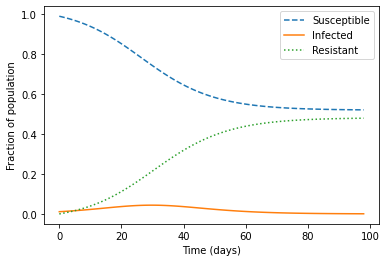

In [13]:
plot_results(S, I, R)

It takes about three weeks (21 days) for the outbreak to get going, and about five weeks (35 days) to peak. The fraction of the population that's infected is never very high, but it adds up. In total, almost half the population gets sick.

✅ Active reading: Add documentation to the `run_simulation` version above using line comments (#).  You don't need to comment for each line, but make sure you explain fully what each part of the code does.

### Using a DataFrame to collect results

If the number of state variables is small, storing them as separate
`Series` objects might not be so bad. But a better alternative is to use a `DataFrame`, which can store more than one column of data  Here's a more concise version of `run_simulation` using a `DataFrame`:

In [14]:
def run_simulation(system, change_func):
    state = make_state(system)
    frame = pd.DataFrame([],columns=state.index)
    frame.loc[0] = state
    
    for t in range(0, system['t_end']):
        frame.loc[t+1] = change_func(t, frame.loc[t], system)
    
    return frame

The second line creates an empty `DataFrame` with one column for each
state variable. Then, before the loop starts, we store the initial
conditions in the `DataFrame` at `0`. Based on the way we've been using
`Series` objects, it is tempting to write:

```
frame[0] = state
```

But when you use the bracket operator with a `DataFrame`, it selects a column, not a row. 
To select a row, we have to use `loc`, like this:

```
frame.loc[0] = system['init']
```

Since the value on the right side is a `Series`, the assignment matches
up the index of the `Series` with the columns of the `DataFrame`; that
is, it assigns the `s` value from `state` to the `s` column of
`frame`, and likewise with `i` and `r`.

<br>

Each time through the loop, we assign the state object we get from `change_func` to the next row of `frame`, thus building step-by-step a 3-column spreadsheet of values.
At the end, we return the spreadsheet (i.e. the DataFrame):

In [15]:
results = run_simulation(system, change_func)
results.head()

,s,i,r
0,0.988889,0.011111,0.000000
1,0.985226,0.011996,0.002778
2,0.981287,0.012936,0.005777
3,0.977055,0.013934,0.009011
4,0.972517,0.014988,0.012494


The columns in the `DataFrame` correspond to the state variables, `s`, `i`, and `r`.
We can use the dot operator to select columns
from a `DataFrame`.  Because each column of the `DataFrame` is a `Series`, we can use the same `plot_results` function that we created earlier:

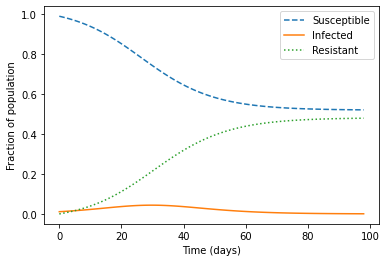

In [16]:
plot_results(results.s, results.i, results.r)

The results are the same as before, now in a more convenient form.

<br>

---


## Summary

This notebook presents an SIR model of infectious disease and two ways to collect the results, using several `Series` objects or a single `DataFrame`.
In the next notebook we'll iterate our model in order to explore the effect of immunization.

<br>

---

## Exercises


### Exercise 1  

Suppose the time between contacts is 4 days and the recovery time is 5 days.  After 14 weeks, how many students, total, have been infected?

In [19]:
# Create initial state and system
iS = 29; iI = 1; iR = 0    
tc = 3; tr = 4; t_end = 14*7

system = make_system(iS,iI,iR,tc,tr,t_end)


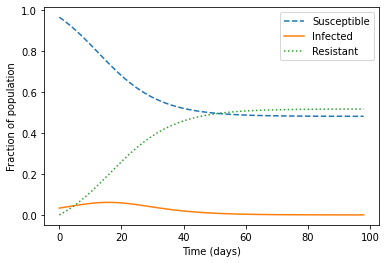

In [20]:
# Use run_simulation and plot_results to display the behavior of the system
results = run_simulation(system,change_func)
plot_results(results.s,results.i,results.r)

### Exercise 2

✅ Describe the effect of the change on the behavior of the system.  Do more people get sick?  Why?  Explain in terms of `gamma` and `beta`.

### Exercise 3

✅ Play with the model by manipulating the parameters.  What combination of `gamma` and `beta` produces the highest levels of infection at a given time?  What combination produces late and early peaks of the epidemic?   Does changing the overall population (increase `iS` while leaving `iI` and `iR` the same) create large changes in the behavior of the epidemic? 